In [1]:
from theano.sandbox import cuda

WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 0: Quadro K620 (CNMeM is disabled, cuDNN 5103)


In [2]:
%cd /home/rdelaviz/Learning/DL/FastAI/courses/deeplearning1/nbs

/home/rdelaviz/Learning/DL/FastAI/courses/deeplearning1/nbs


In [3]:
%matplotlib inline
import utils; reload(utils)
from utils import *
from __future__ import division, print_function

Using Theano backend.


In [4]:
#path = "data/ml-20m/"
path = "data/ml-small/"
model_path = path + 'models/'
if not os.path.exists(model_path): os.mkdir(model_path)
batch_size=64

## Set up data

We're working with the movielens data, which contains one rating per row, like this:

In [5]:
ratings = pd.read_csv(path+'ratings.csv')
ratings.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


In [6]:
ratings.shape

(100004, 4)

Just for display purposes, let's read in the movie names too.

In [7]:
movie_names = pd.read_csv(path+'movies.csv').set_index('movieId')['title'].to_dict()

In [9]:
users = ratings.userId.unique()
movies = ratings.movieId.unique()

In [10]:
userid2idx = {o:i for i,o in enumerate(users)}
movieid2idx = {o:i for i,o in enumerate(movies)}

We update the movie and user ids so that they are contiguous integers, which we want when using embeddings.

In [11]:
ratings.movieId = ratings.movieId.apply(lambda x: movieid2idx[x])
ratings.userId = ratings.userId.apply(lambda x: userid2idx[x])

In [12]:
ratings.head()

,userId,movieId,rating,timestamp
0,0,0,2.5,1260759144
1,0,1,3.0,1260759179
2,0,2,3.0,1260759182
3,0,3,2.0,1260759185
4,0,4,4.0,1260759205


In [13]:
user_min, user_max, movie_min, movie_max = (ratings.userId.min(), 
    ratings.userId.max(), ratings.movieId.min(), ratings.movieId.max())
user_min, user_max, movie_min, movie_max

(0, 670, 0, 9065)

In [14]:
n_users = ratings.userId.nunique()
n_movies = ratings.movieId.nunique()
n_users, n_movies

(671, 9066)

This is the number of latent factors in each embedding.

In [15]:
n_factors = 50

In [16]:
np.random.seed = 42

Randomly split into training and validation.

In [67]:
m = np.random.rand(10) < 0.5
print(m)
msk = np.random.rand(len(ratings)) < 0.8
trn = ratings[msk]
val = ratings[~msk]
trn.shape, val.shape 

[False False  True False False  True  True False False  True]


((79947, 4), (20057, 4))

## Create subset for Excel

We create a crosstab of the most popular movies and most movie-addicted users which we'll copy into Excel for creating a simple example. This isn't necessary for any of the modeling below however.

In [68]:
g=ratings.groupby('userId')['rating'].count()
topUsers=g.sort_values(ascending=False)[:15]

In [69]:
topUsers

userId
546    2391
563    1868
623    1735
14     1700
72     1610
451    1340
467    1291
379    1063
310    1019
29     1011
293     947
508     923
579     922
212     910
211     876
Name: rating, dtype: int64

In [70]:
g=ratings.groupby('movieId')['rating'].count()
topMovies=g.sort_values(ascending=False)[:15]

In [71]:
top_r = ratings.join(topUsers, rsuffix='_r', how='inner', on='userId')

In [72]:
top_r.head()

,userId,movieId,rating,timestamp,rating_r
962,14,417,2.0,997938310,1700
963,14,650,2.0,1134521380,1700
964,14,651,4.5,1093070098,1700
965,14,652,4.0,1040205753,1700
966,14,20,3.0,1093028290,1700


In [73]:
top_r = top_r.join(topMovies, rsuffix='_r', how='inner', on='movieId')

In [74]:
top_r.head()

,userId,movieId,rating,timestamp,rating_r,rating_r
962,14,417,2.0,997938310,1700,247
5048,29,417,4.0,944943070,1011,247
10214,72,417,5.0,1303464840,1610,247
28390,211,417,3.0,1218405007,876,247
29266,212,417,3.0,1462637445,910,247


In [75]:
pd.crosstab(top_r.userId, top_r.movieId, top_r.rating, aggfunc=np.sum)

movieId,27,49,57,72,79,89,92,99,143,179,180,197,402,417,505
userId,,,,,,,,,,,,,,,
14,3.0,5.0,1.0,3.0,4.0,4.0,5.0,2.0,5.0,5.0,4.0,5.0,5.0,2.0,5.0
29,5.0,5.0,5.0,4.0,5.0,4.0,4.0,5.0,4.0,4.0,5.0,5.0,3.0,4.0,5.0
72,4.0,5.0,5.0,4.0,5.0,3.0,4.5,5.0,4.5,5.0,5.0,5.0,4.5,5.0,4.0
211,5.0,4.0,4.0,3.0,5.0,3.0,4.0,4.5,4.0,NaN,3.0,3.0,5.0,3.0,NaN
212,2.5,NaN,2.0,5.0,NaN,4.0,2.5,NaN,5.0,5.0,3.0,3.0,4.0,3.0,2.0
293,3.0,NaN,4.0,4.0,4.0,3.0,NaN,3.0,4.0,4.0,4.5,4.0,4.5,4.0,NaN
310,3.0,3.0,5.0,4.5,5.0,4.5,2.0,4.5,4.0,3.0,4.5,4.5,4.0,3.0,4.0
379,5.0,5.0,5.0,4.0,NaN,4.0,5.0,4.0,4.0,4.0,NaN,3.0,5.0,4.0,4.0
451,4.0,5.0,4.0,5.0,4.0,4.0,5.0,5.0,4.0,4.0,4.0,4.0,2.0,3.5,5.0


## Dot product

The most basic model is a dot product of a movie embedding and a user embedding. Let's see how well that works:

In [78]:
user_in = Input(shape=(1,), dtype='int64', name='user_in')
u = Embedding(n_users, n_factors, input_length=1, W_regularizer=l2(1e-4))(user_in)
movie_in = Input(shape=(1,), dtype='int64', name='movie_in')
m = Embedding(n_movies, n_factors, input_length=1, W_regularizer=l2(1e-4))(movie_in)

In [79]:
x = merge([u, m], mode='dot')
x = Flatten()(x)
model = Model([user_in, movie_in], x)
model.compile(Adam(0.001), loss='mse')

In [80]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
user_in (InputLayer)             (None, 1)             0                                            
____________________________________________________________________________________________________
movie_in (InputLayer)            (None, 1)             0                                            
____________________________________________________________________________________________________
embedding_5 (Embedding)          (None, 1, 50)         33550       user_in[0][0]                    
____________________________________________________________________________________________________
embedding_6 (Embedding)          (None, 1, 50)         453300      movie_in[0][0]                   
___________________________________________________________________________________________

In [81]:
model.fit([trn.userId, trn.movieId], trn.rating, batch_size=64, nb_epoch=1, 
          validation_data=([val.userId, val.movieId], val.rating))

Train on 79947 samples, validate on 20057 samples
Epoch 1/1
79947/79947 [==============================] - 12s - loss: 9.9905 - val_loss: 4.3042


In [82]:
#Rahim
tensor_a = Input(shape=(32,2))
tensor_b = Input(shape=(32,2))
merged_tensor = merge([tensor_a, tensor_b], mode='concat', concat_axis=1)


In [83]:
merged_tensor.ndim, tensor_a.ndim


(3, 3)

In [84]:
model.optimizer.lr=0.01

In [85]:
model.fit([trn.userId, trn.movieId], trn.rating, batch_size=64, nb_epoch=3, 
          validation_data=([val.userId, val.movieId], val.rating))

Train on 79947 samples, validate on 20057 samples
Epoch 1/3
79947/79947 [==============================] - 12s - loss: 3.1538 - val_loss: 2.8136
Epoch 2/3
79947/79947 [==============================] - 12s - loss: 2.4062 - val_loss: 2.6049
Epoch 3/3
79947/79947 [==============================] - 12s - loss: 2.2262 - val_loss: 2.5610


In [86]:
model.optimizer.lr=0.001

In [87]:
model.fit([trn.userId, trn.movieId], trn.rating, batch_size=64, nb_epoch=6, 
          validation_data=([val.userId, val.movieId], val.rating))

Train on 79947 samples, validate on 20057 samples
Epoch 1/6
79947/79947 [==============================] - 12s - loss: 2.1557 - val_loss: 2.5405
Epoch 2/6
79947/79947 [==============================] - 12s - loss: 2.1170 - val_loss: 2.5507
Epoch 3/6
79947/79947 [==============================] - 12s - loss: 2.0930 - val_loss: 2.5548
Epoch 4/6
79947/79947 [==============================] - 12s - loss: 2.0728 - val_loss: 2.5575
Epoch 5/6
79947/79947 [==============================] - 12s - loss: 2.0534 - val_loss: 2.5652
Epoch 6/6
79947/79947 [==============================] - 12s - loss: 2.0367 - val_loss: 2.5711


The [best benchmarks](http://www.librec.net/example.html) are a bit over 0.9, so this model doesn't seem to be working that well...

##  Bias

The problem is likely to be that we don't have bias terms - that is, a single bias for each user and each movie representing how positive or negative each user is, and how good each movie is. We can add that easily by simply creating an embedding with one output for each movie and each user, and adding it to our output.

In [88]:
def embedding_input(name, n_in, n_out, reg):
    inp = Input(shape=(1,), dtype='int64', name=name)
    return inp, Embedding(n_in, n_out, input_length=1, W_regularizer=l2(reg))(inp)

In [89]:
user_in, u = embedding_input('user_in', n_users, n_factors, 1e-4)
movie_in, m = embedding_input('movie_in', n_movies, n_factors, 1e-4)

In [90]:
type(u),type(user_in)

(theano.tensor.var.TensorVariable, theano.tensor.var.TensorVariable)

In [95]:
def create_bias(inp, n_in):
    x = Embedding(n_in, 1, input_length=1)(inp)
    return Flatten()(x)

In [96]:
ub = create_bias(user_in, n_users)
mb = create_bias(movie_in, n_movies)

In [97]:
x = merge([u, m], mode='dot')
x = Flatten()(x)
x = merge([x, ub], mode='sum')
x = merge([x, mb], mode='sum')
model = Model([user_in, movie_in], x)
model.compile(Adam(0.001), loss='mse')

In [98]:
%matplotlib inline

In [183]:
import matplotlib.image as mpimg
from keras.utils.visualize_util import plot 
def plotModel(model, show_shapes=False, tmpFileName="tmpModel.png", imgSize=(20,20)):
    plot(model, tmpFileName,show_shapes=show_shapes)
    image = mpimg.imread(tmpFileName)
    fig = plt.figure(figsize= imgSize)
    plt.imshow(image)
    plt.axis("off")

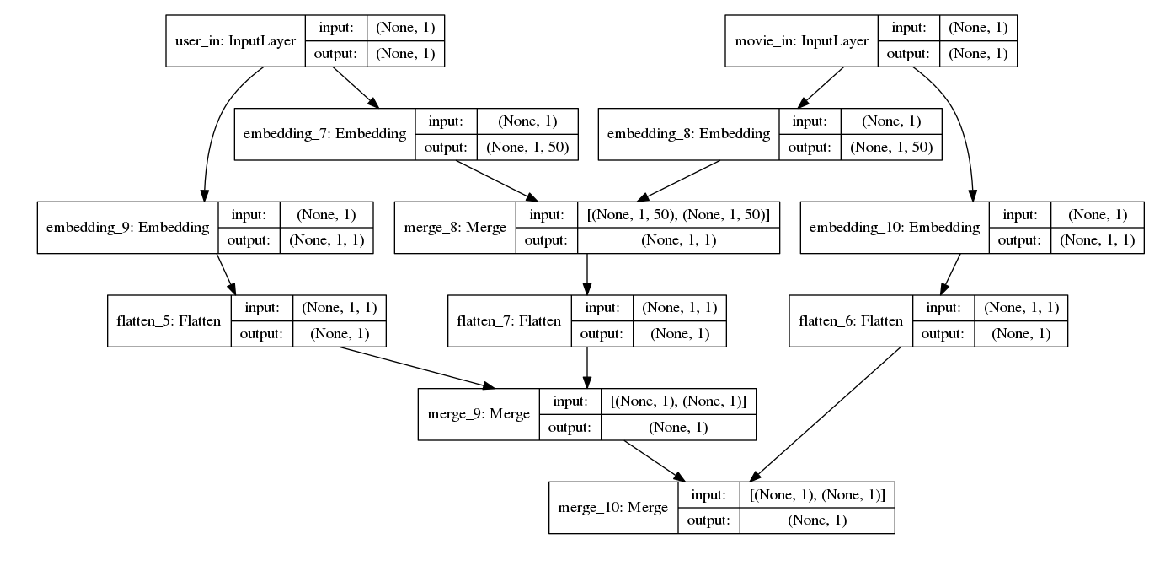

In [185]:
plotModel(model, show_shapes=True)

In [122]:
model.fit([trn.userId, trn.movieId], trn.rating, batch_size=64, nb_epoch=1, 
          validation_data=([val.userId, val.movieId], val.rating))

Train on 79947 samples, validate on 20057 samples
Epoch 1/1
79947/79947 [==============================] - 17s - loss: 8.9514 - val_loss: 3.5792


In [123]:
model.optimizer.lr=0.01

In [124]:
model.fit([trn.userId, trn.movieId], trn.rating, batch_size=64, nb_epoch=6, 
          validation_data=([val.userId, val.movieId], val.rating))

Train on 79947 samples, validate on 20057 samples
Epoch 1/6
79947/79947 [==============================] - 11s - loss: 2.6079 - val_loss: 2.3078
Epoch 2/6
79947/79947 [==============================] - 11s - loss: 1.9857 - val_loss: 2.1053
Epoch 3/6
79947/79947 [==============================] - 11s - loss: 1.8188 - val_loss: 2.0162
Epoch 4/6
79947/79947 [==============================] - 11s - loss: 1.7240 - val_loss: 1.9409
Epoch 5/6
79947/79947 [==============================] - 11s - loss: 1.6448 - val_loss: 1.8772
Epoch 6/6
79947/79947 [==============================] - 11s - loss: 1.5722 - val_loss: 1.8128


In [125]:
model.optimizer.lr=0.001

In [126]:
model.fit([trn.userId, trn.movieId], trn.rating, batch_size=64, nb_epoch=10, 
          validation_data=([val.userId, val.movieId], val.rating))

Train on 79947 samples, validate on 20057 samples
Epoch 1/10
79947/79947 [==============================] - 11s - loss: 1.5012 - val_loss: 1.7469
Epoch 2/10
79947/79947 [==============================] - 11s - loss: 1.4325 - val_loss: 1.6871
Epoch 3/10
79947/79947 [==============================] - 11s - loss: 1.3645 - val_loss: 1.6351
Epoch 4/10
79947/79947 [==============================] - 11s - loss: 1.2987 - val_loss: 1.5746
Epoch 5/10
79947/79947 [==============================] - 11s - loss: 1.2361 - val_loss: 1.5275
Epoch 6/10
79947/79947 [==============================] - 11s - loss: 1.1759 - val_loss: 1.4778
Epoch 7/10
79947/79947 [==============================] - 11s - loss: 1.1185 - val_loss: 1.4350
Epoch 8/10
79947/79947 [==============================] - 11s - loss: 1.0646 - val_loss: 1.3868
Epoch 9/10
79947/79947 [==============================] - 11s - loss: 1.0123 - val_loss: 1.3496
Epoch 10/10
79947/79947 [==============================] - 11s - loss: 0.9632 - val_lo

In [128]:
model.fit([trn.userId, trn.movieId], trn.rating, batch_size=64, nb_epoch=5, 
          validation_data=([val.userId, val.movieId], val.rating))

Train on 79947 samples, validate on 20057 samples
Epoch 1/5
79947/79947 [==============================] - 11s - loss: 0.7324 - val_loss: 1.1422
Epoch 2/5
79947/79947 [==============================] - 11s - loss: 0.7049 - val_loss: 1.1202
Epoch 3/5
79947/79947 [==============================] - 11s - loss: 0.6792 - val_loss: 1.1031
Epoch 4/5
79947/79947 [==============================] - 11s - loss: 0.6568 - val_loss: 1.0874
Epoch 5/5
79947/79947 [==============================] - 11s - loss: 0.6369 - val_loss: 1.0742


This result is quite a bit better than the best benchmarks that we could find with a quick google search - so looks like a great approach!

In [86]:
model.save_weights(model_path+'bias.h5')

In [28]:
model.load_weights(model_path+'bias.h5')

We can use the model to generate predictions by passing a pair of ints - a user id and a movie id. For instance, this predicts that user #3 would really enjoy movie #6.

In [29]:
model.predict([np.array([3]), np.array([6])])

array([[ 4.7485]], dtype=float32)

## Analyze results

To make the analysis of the factors more interesting, we'll restrict it to the top 2000 most popular movies.

In [152]:
g=ratings.groupby('movieId')['rating'].count()
topMovies=g.sort_values(ascending=False)[:2000]
topMovies = np.array(topMovies.index)

First, we'll look at the movie bias term. We create a 'model' - which in keras is simply a way of associating one or more inputs with one more more outputs, using the functional API. Here, our input is the movie id (a single id), and the output is the movie bias (a single float).

In [153]:
type(mb), type(movie_in)

(theano.tensor.var.TensorVariable, theano.tensor.var.TensorVariable)

In [154]:
get_movie_bias = Model(movie_in, mb)
movie_bias = get_movie_bias.predict(topMovies)
movie_ratings = [(b[0], movie_names[movies[i]]) for i,b in zip(topMovies,movie_bias)]

In [155]:
get_movie_bias.summary()

Now we can look at the top and bottom rated movies. These ratings are corrected for different levels of reviewer sentiment, as well as different types of movies that different reviewers watch.

In [156]:
sorted(movie_ratings, key=itemgetter(0))[:15]

[(-0.65797752, 'Battlefield Earth (2000)'),
 (-0.35397643, 'Super Mario Bros. (1993)'),
 (-0.28650537, 'Speed 2: Cruise Control (1997)'),
 (-0.27835679, 'Blade: Trinity (2004)'),
 (-0.22083858, 'House on Haunted Hill (1999)'),
 (-0.21508695, 'Jaws 3-D (1983)'),
 (-0.18983969, '2 Fast 2 Furious (Fast and the Furious 2, The) (2003)'),
 (-0.17955627, 'Blame It on Rio (1984)'),
 (-0.1425721, 'Wild Wild West (1999)'),
 (-0.13318841, 'Spice World (1997)'),
 (-0.11903191, 'Police Academy 4: Citizens on Patrol (1987)'),
 (-0.08920455, 'Police Academy 6: City Under Siege (1989)'),
 (-0.072411731, 'Howard the Duck (1986)'),
 (-0.061318502, 'Police Academy 5: Assignment: Miami Beach (1988)'),
 (-0.045635995, 'Haunting, The (1999)')]

In [157]:
sorted(movie_ratings, key=itemgetter(0), reverse=True)[:15]

[(1.618614, 'Tom Jones (1963)'),
 (1.5899024, 'Shawshank Redemption, The (1994)'),
 (1.5732634, '3:10 to Yuma (2007)'),
 (1.5732423, 'Band of Brothers (2001)'),
 (1.5606397, "Howl's Moving Castle (Hauru no ugoku shiro) (2004)"),
 (1.5469296, 'Three Colors: Blue (Trois couleurs: Bleu) (1993)'),
 (1.5451269, 'Three Colors: Red (Trois couleurs: Rouge) (1994)'),
 (1.5264505, 'Her (2013)'),
 (1.5221579, 'Blood Simple (1984)'),
 (1.5196425, 'Harry Potter and the Deathly Hallows: Part 2 (2011)'),
 (1.5030547, 'The Imitation Game (2014)'),
 (1.4907173, 'Smoke (1995)'),
 (1.4610773, 'My Neighbor Totoro (Tonari no Totoro) (1988)'),
 (1.4610255, 'Happiness (1998)'),
 (1.4580752, 'Porco Rosso (Crimson Pig) (Kurenai no buta) (1992)')]

We can now do the same thing for the embeddings.

In [158]:
get_movie_emb = Model(movie_in, m)
movie_emb = np.squeeze(get_movie_emb.predict([topMovies]))
movie_emb.shape

(2000, 50)

Because it's hard to interpret 50 embeddings, we use [PCA](https://plot.ly/ipython-notebooks/principal-component-analysis/) to simplify them down to just 3 vectors. 

In [159]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
movie_pca = pca.fit(movie_emb.T).components_

In [160]:
movie_pca

array([[ 0.0527,  0.0577,  0.0679, ...,  0.0085, -0.0024, -0.0041],
       [-0.0703,  0.0293, -0.035 , ..., -0.0011,  0.0018, -0.0115],
       [-0.0086, -0.0654, -0.0065, ...,  0.007 ,  0.0057, -0.0089]])

In [161]:
fac0 = movie_pca[0]

In [162]:
fac0

array([ 0.0527,  0.0577,  0.0679, ...,  0.0085, -0.0024, -0.0041])

In [163]:
movie_comp = [(f, movie_names[movies[i]]) for f,i in zip(fac0, topMovies)]

Here's the 1st component. It seems to be 'critically acclaimed' or 'classic'.

In [164]:
sorted(movie_comp, key=itemgetter(0), reverse=True)[:10]

[(0.072104994911604492, 'Usual Suspects, The (1995)'),
 (0.071084943911936885, 'Silence of the Lambs, The (1991)'),
 (0.069497675262816569, 'Toy Story (1995)'),
 (0.068319251604308642, 'Wallace & Gromit: The Wrong Trousers (1993)'),
 (0.067943627031508622, 'Shawshank Redemption, The (1994)'),
 (0.067554963416233599,
  "Amelie (Fabuleux destin d'Am\xc3\xa9lie Poulain, Le) (2001)"),
 (0.064729345473437019, "Schindler's List (1993)"),
 (0.0622128648497179, 'Being John Malkovich (1999)'),
 (0.061531824814799026, 'Groundhog Day (1993)'),
 (0.061344733459771608, 'American Beauty (1999)')]

In [165]:
sorted(movie_comp, key=itemgetter(0))[:10]

[(-0.036196079396649518, 'Anaconda (1997)'),
 (-0.021070729848777552, 'Junior (1994)'),
 (-0.020669350082035017, 'RoboCop 3 (1993)'),
 (-0.020589422715087843, 'Barb Wire (1996)'),
 (-0.019446725676461711, 'Three Musketeers, The (1993)'),
 (-0.018957190065707168, 'Son in Law (1993)'),
 (-0.018460664787328218, 'Police Academy 4: Citizens on Patrol (1987)'),
 (-0.017846251956424988, 'Mission to Mars (2000)'),
 (-0.017700624810112291, "Charlie's Angels: Full Throttle (2003)"),
 (-0.016487083246749586, 'Battlefield Earth (2000)')]

In [166]:
fac1 = movie_pca[1]

In [167]:
movie_comp = [(f, movie_names[movies[i]]) for f,i in zip(fac1, topMovies)]

The 2nd is 'hollywood blockbuster'.

In [168]:
sorted(movie_comp, key=itemgetter(0), reverse=True)[:10]

[(0.068713037634325611, 'Annie Hall (1977)'),
 (0.062789734805192177, 'Clockwork Orange, A (1971)'),
 (0.060143903460851127, '2001: A Space Odyssey (1968)'),
 (0.057436221387261774, 'Brokeback Mountain (2005)'),
 (0.057181439568234557, 'Napoleon Dynamite (2004)'),
 (0.056110596526221634, 'Harold and Maude (1971)'),
 (0.055511479110685796, 'Mulholland Drive (2001)'),
 (0.053883079319501724, 'Big Lebowski, The (1998)'),
 (0.053677409906652429, 'City Lights (1931)'),
 (0.052010031006816247, 'Bringing Up Baby (1938)')]

In [169]:
sorted(movie_comp, key=itemgetter(0))[:10]

[(-0.10430560245360232, 'Independence Day (a.k.a. ID4) (1996)'),
 (-0.092626580860324353, 'Armageddon (1998)'),
 (-0.092236121446874028, 'Speed (1994)'),
 (-0.081279594636968072, 'Titanic (1997)'),
 (-0.081100808427709059, 'Stargate (1994)'),
 (-0.080195484059752284, 'Waterworld (1995)'),
 (-0.079943430450411593, 'Star Trek: Generations (1994)'),
 (-0.078091862163797141, 'Braveheart (1995)'),
 (-0.076718035851699978, 'Star Wars: Episode I - The Phantom Menace (1999)'),
 (-0.076345416585313894, 'Jurassic Park (1993)')]

In [170]:
fac2 = movie_pca[2]

In [171]:
movie_comp = [(f, movie_names[movies[i]]) for f,i in zip(fac2, topMovies)]

The 3rd is 'violent vs happy'.

In [172]:
sorted(movie_comp, key=itemgetter(0), reverse=True)[:10]

[(0.094115406557375311, 'Beauty and the Beast (1991)'),
 (0.0915176152847446, 'Babe (1995)'),
 (0.078267665954109888, 'Sabrina (1995)'),
 (0.074314977525045192, 'While You Were Sleeping (1995)'),
 (0.073214698869400616, 'Wallace & Gromit: The Wrong Trousers (1993)'),
 (0.071581381557518156, 'Sleepless in Seattle (1993)'),
 (0.069577620866436193, 'Erin Brockovich (2000)'),
 (0.068809870979552726, "You've Got Mail (1998)"),
 (0.06777799339917559, 'Chicago (2002)'),
 (0.065477890283807821, 'Some Like It Hot (1959)')]

In [173]:
sorted(movie_comp, key=itemgetter(0))[:10]

[(-0.081349315541345682, 'Fight Club (1999)'),
 (-0.080914070715952011, 'Seven (a.k.a. Se7en) (1995)'),
 (-0.080160276785359225, 'Happy Gilmore (1996)'),
 (-0.079812263639052791, 'American Psycho (2000)'),
 (-0.068899648493934068, 'Fear and Loathing in Las Vegas (1998)'),
 (-0.067457821318235703, 'Spaceballs (1987)'),
 (-0.065358679018859667, 'Pulp Fiction (1994)'),
 (-0.065347143498843935, 'Twelve Monkeys (a.k.a. 12 Monkeys) (1995)'),
 (-0.064876787196209304, 'Starship Troopers (1997)'),
 (-0.06367809529088321, 'Lethal Weapon (1987)')]

We can draw a picture to see how various movies appear on the map of these components. This picture shows the 1st and 3rd components.

In [174]:
reload(sys)
sys.setdefaultencoding('utf8')

In [175]:
fac0

array([ 0.0527,  0.0577,  0.0679, ...,  0.0085, -0.0024, -0.0041])

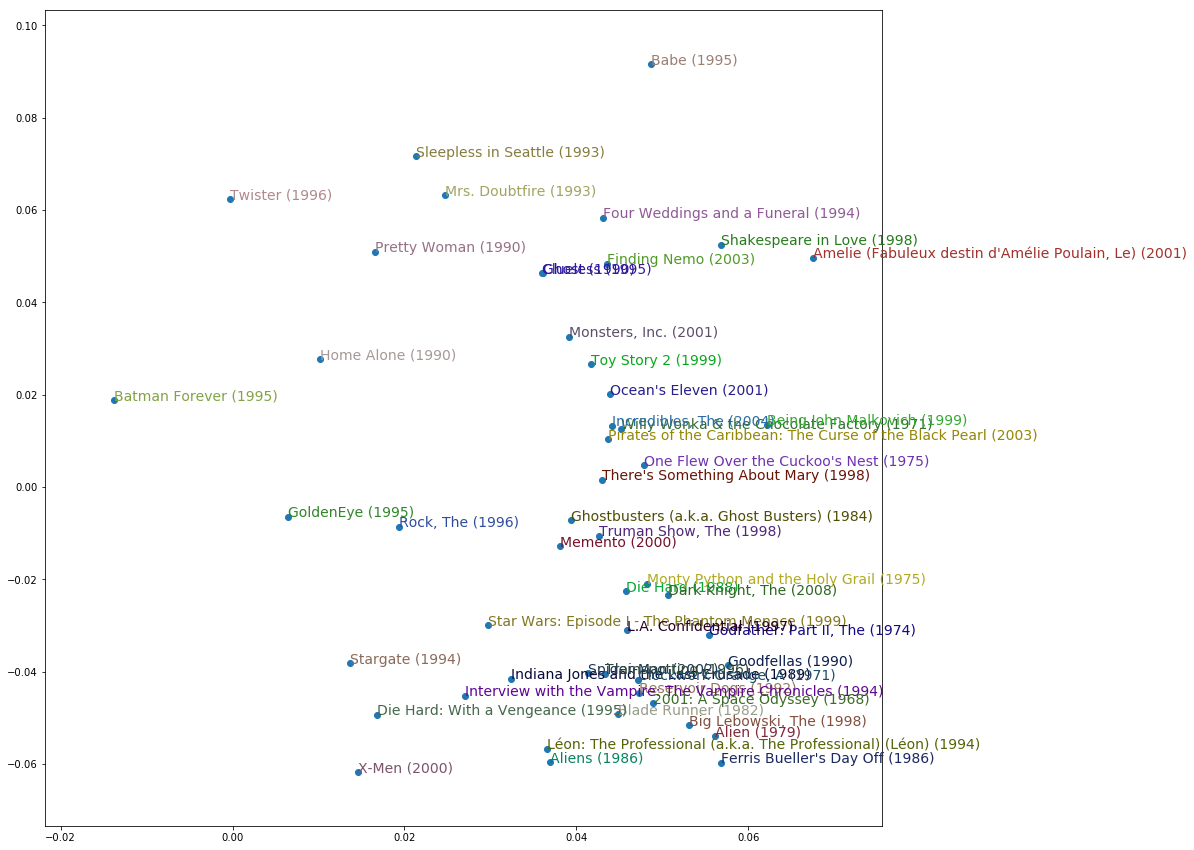

In [176]:
start=50; end=100
X = fac0[start:end]
Y = fac2[start:end]
plt.figure(figsize=(15,15))
plt.scatter(X, Y)
for i, x, y in zip(topMovies[start:end], X, Y):
    plt.text(x,y,movie_names[movies[i]], color=np.random.rand(3)*0.7, fontsize=14)
plt.show()

##  Neural net

Rather than creating a special purpose architecture (like our dot-product with bias earlier), it's often both easier and more accurate to use a standard neural network. Let's try it! Here, we simply concatenate the user and movie embeddings into a single vector, which we feed into the neural net.

In [186]:
user_in, u = embedding_input('user_in', n_users, n_factors, 1e-4)
movie_in, m = embedding_input('movie_in', n_movies, n_factors, 1e-4)

In [187]:
x = merge([u, m], mode='concat')
x = Flatten()(x)
x = Dropout(0.3)(x)
x = Dense(70, activation='relu')(x)
x = Dropout(0.75)(x)
x = Dense(1)(x)
nn = Model([user_in, movie_in], x)
nn.compile(Adam(0.001), loss='mse')

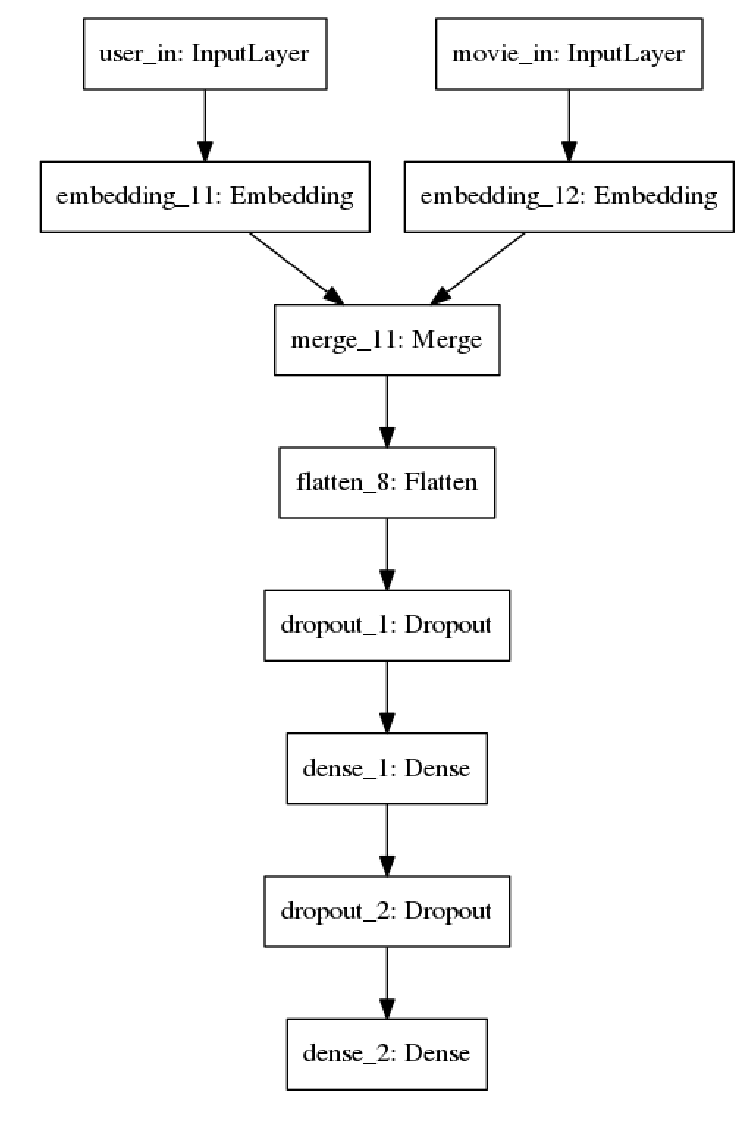

In [188]:
plotModel(nn)

In [189]:
nn.fit([trn.userId, trn.movieId], trn.rating, batch_size=64, nb_epoch=8, 
          validation_data=([val.userId, val.movieId], val.rating))

This improves on our already impressive accuracy even further!